In [8]:
from datasets import SyntheticDataset
from crowd_evaluation import OldEvaluator, ConfidenceEvaluatorC, MajorityEvaluator, VoteAggregator
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [2]:
from joblib import Memory, Parallel, delayed
memory = Memory('accuracy_vs_spam', verbose=0)

@memory.cache
def calc_fraction_of_wrong_interval_estimates(
        num_samples: int,
        num_workers: int,
        confidence: float,
        evaluator_name: str,
        iter_count: int,
        error_rates: list[float],
        spammer_error_rates: list[float],
        spam_level: float):

    correct_interval_estimates = np.zeros(iter_count * num_workers, dtype=np.float32)
    error_rate_estimation_errors = np.zeros(iter_count * num_workers, dtype=np.float32)
    int_sizes = np.zeros(iter_count * num_workers, dtype=np.float32)

    # Saves for every sample generated whether the
    # majority vote estimates the label correctly (=1) or not (=0)
    majority_vote_estimations = np.zeros(iter_count * num_samples)

    # Saves for every sample generated whether the
    # weighted vote estimates the label correctly (=1) or not (=0)
    weighted_vote_estimations = np.zeros(iter_count * num_samples)

    for i in range(iter_count):
        spammer_p_true = np.random.choice(spammer_error_rates, size=num_workers)
        normal_p_true = np.random.choice(error_rates, size=num_workers)
        p_true = np.where(np.random.choice([1, 0], num_workers, p=[spam_level, 1-spam_level]) == 1, spammer_p_true, normal_p_true)
        dataset = SyntheticDataset(num_samples=num_samples, num_workers=num_workers, p_true=p_true)

        if evaluator_name == 'old':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='exhaustive'
            )
        elif evaluator_name == 'old greedy':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='greedy'
            )
        elif evaluator_name == 'majority':
            evaluator = MajorityEvaluator(dataset)
            ps = evaluator.evaluate_workers(dataset.workers)
            confs = np.zeros(num_workers)
        else:
            evaluator = ConfidenceEvaluatorC(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
            )

        ground_truth = dataset.get_ground_truth_for_samples(dataset.samples)
        maj_vote = VoteAggregator.majority_vote(dataset, dataset.samples)
        weighted_vote = VoteAggregator.weighted_vote(dataset, dataset.samples, ps, 0.5)

        min_limit, max_limit = ps-confs, ps+confs
        correct_interval_estimates[i*num_workers:(i+1)*num_workers] = np.where((min_limit <= p_true) & (p_true <= max_limit), 1, 0)
        int_sizes[i*num_workers:(i+1)*num_workers] = 2*confs
        error_rate_estimation_errors[i*num_workers:(i+1)*num_workers] = np.abs(ps - p_true)

        majority_vote_estimations[i*num_samples:(i+1)*num_samples] = (ground_truth == maj_vote)
        weighted_vote_estimations[i*num_samples:(i+1)*num_samples] = (ground_truth == weighted_vote)

    return correct_interval_estimates, int_sizes, error_rate_estimation_errors, majority_vote_estimations, weighted_vote_estimations

In [ ]:
from tqdm.notebook import tqdm
import time

start = time.time()

spam_levels = np.arange(0, 0.55, 0.05)
spammer_error_rates = [0.45, 0.5, 0.55]
error_rates = [0.1, 0.15, 0.05]
num_workers = 7
num_samples = 500
iteration_count = 100
evaluator_names = ['new', 'old greedy']
confidence_level = 0.8

# Stores whether the interval contained the true error rate for every dataset.
correct_interval_estimates = dict()
# Stores the average accuracy for every configuration.
accuracies = dict()
# Stores all measured interval sizes for every dataset
interval_sizes = dict()
# Stores the average interval sizes for every configuration
average_interval_sizes = dict()
# Stores all estimation error for every dataset
estimation_errors = dict()
# Stores the average estimation error for every configuration
average_estimation_errors = dict()
majority_vote_estimation_accuracies = dict()
weighted_vote_estimation_accuracies = dict()

for spam_level in spam_levels:
    correct_interval_estimates[(num_samples, num_workers)] = dict()
    accuracies[(num_samples, num_workers)] = dict()
    interval_sizes[(num_samples, num_workers)] = dict()
    average_interval_sizes[(num_samples, num_workers)] = dict()
    estimation_errors[(num_samples, num_workers)] = dict()
    average_estimation_errors[(num_samples, num_workers)] = dict()
    majority_vote_estimation_accuracies[(num_samples, num_workers)] = dict()
    weighted_vote_estimation_accuracies[(num_samples, num_workers)] = dict()

    for t in evaluator_names:
        print('num_workers: ' + str(num_workers) + ', num_tasks: ' + str(num_samples) + ', evaluator: ' + t)
        res = Parallel(n_jobs=7)(delayed(calc_fraction_of_wrong_interval_estimates)
                (num_samples, num_workers, confidence_level, t, iteration_count, error_rates, spammer_error_rates, spam_level) for spam_level in tqdm(spam_levels))

        correct_interval_estimates_results = np.array([x[0] for x in res])
        interval_sizes_results = np.array([x[1] for x in res])
        est_errs_results = np.array([x[2] for x in  res])
        maj_vote_results = np.array([x[3] for x in res])
        weighted_vote_results = np.array([x[4] for x in res])

        accuracies[(num_samples, num_workers)][t] = np.array([np.sum(correct_interval_estimates_results[i]) for i in range(len(spam_levels))]) / (num_workers * iteration_count)
        correct_interval_estimates[(num_samples, num_workers)][t] = correct_interval_estimates_results
        interval_sizes[(num_samples, num_workers)][t] = interval_sizes_results
        average_interval_sizes[(num_samples, num_workers)][t] = np.array([np.mean(interval_sizes_results[i]) for i in range(len(spam_levels))])
        estimation_errors[(num_samples, num_workers)][t] = est_errs_results
        average_estimation_errors[(num_samples, num_workers)][t] = np.array([np.mean(est_errs_results[i]) for i in range(len(spam_levels))])
        majority_vote_estimation_accuracies[(num_samples, num_workers)][t] = np.array([np.mean(maj_vote_results[i]) for i in range(len(spam_levels))])
        weighted_vote_estimation_accuracies[(num_samples, num_workers)][t] = np.array([np.mean(weighted_vote_results[i]) for i in range(len(spam_levels))])

end = time.time()
print('Elapsed time:', end-start)

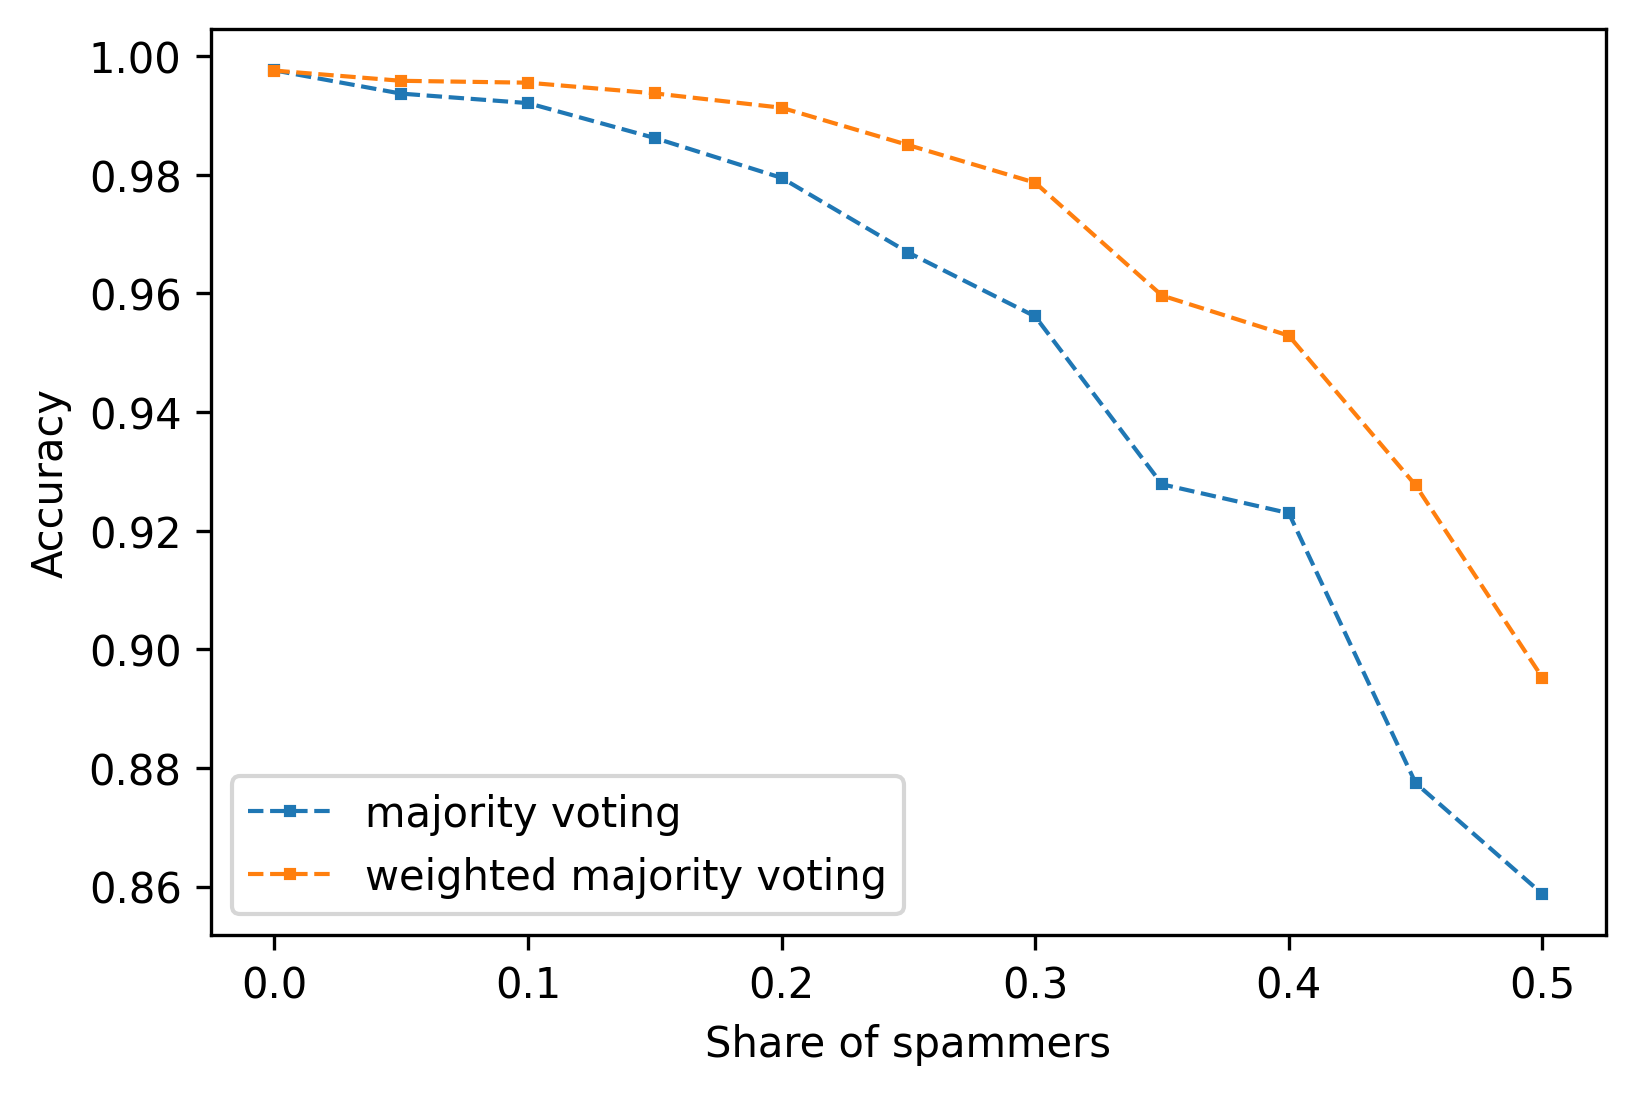

In [22]:
plt.plot(spam_levels, majority_vote_estimation_accuracies[(500, 7)]['new'], label='majority voting',
         marker='s', linestyle='--', linewidth=1, markersize=2)
plt.plot(spam_levels, weighted_vote_estimation_accuracies[(500, 7)]['new'], label='weighted majority voting',
         marker='s', linestyle='--', linewidth=1, markersize=2)

plt.xlabel('Share of spammers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

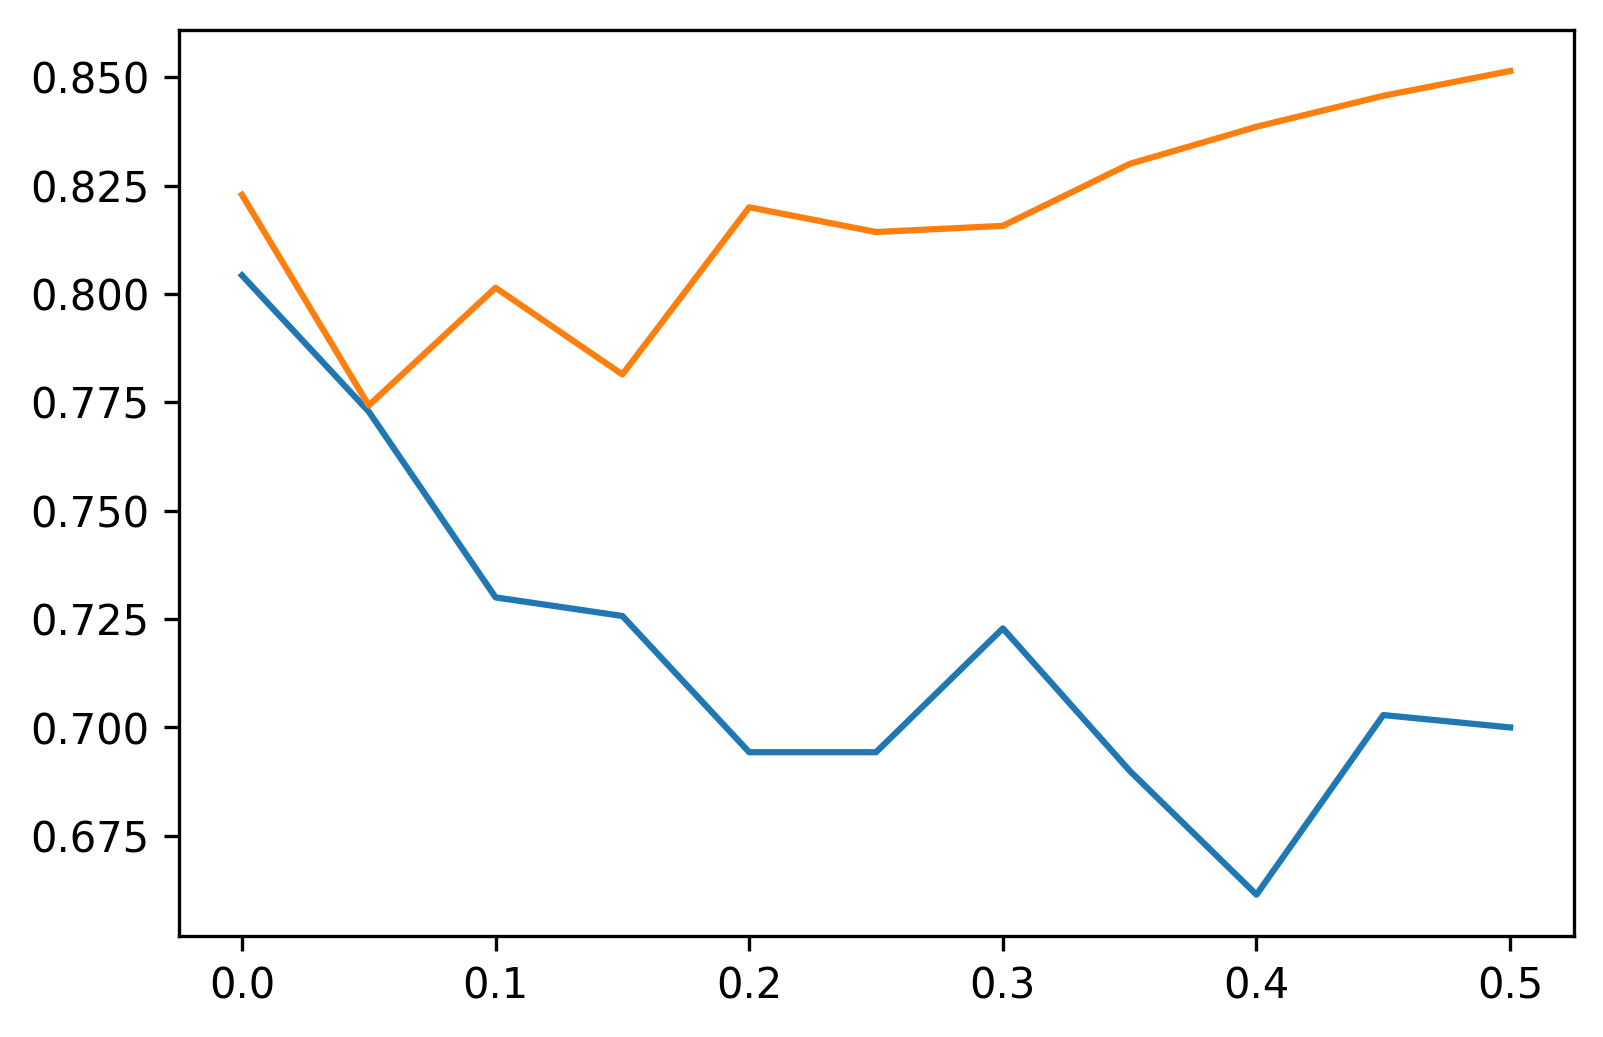

In [19]:
plt.plot(spam_levels, accuracies[(500, 7)]['new'])
plt.plot(spam_levels, accuracies[(500, 7)]['old greedy'])